https://arxiv.org/ftp/arxiv/papers/1305/1305.6143.pdf

In [10]:
import pandas as pd
import pathlib
import shlex
import re
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import csv

from nltk.tokenize import sent_tokenize
from nltk.stem import SnowballStemmer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [11]:
def clean_text_for_language_model(text, remove_users=True, remove_urls=True, remove_numbers=True):
    """
    Cleans text for deep learning language models, applies pre tokenization

    :param text: Str, text string

    :return: cleaned string
    """

    re_repetition = re.compile(r'(\S)(\1{3,})') #repetition of multiple non-whitespace characters
    re_word_repetition = re.compile(r'(\b\w+\W+)(\1{3,})') #repetition of multiple words

    s = text
    s = re_repetition.sub(replace_repeated_character, s)
    s = re_word_repetition.sub(replace_repeated_word, s)
    s = lower_and_add_toks_for_case(s)
    s = add_spaces_to_hashtags_and_slashes(s)
    s = remove_multiple_whitespace_from_string(s)
    s = add_start_of_doc_tokens(s)
    s = replace_repeated_punc(s)
    if remove_numbers:
        s = replace_numbers(s)
    if remove_users:
        s = extract_mentioned_users(s,
                                    remove_users=False,
                                    replace_with_token=True,
                                    token_to_replace='[USER]')[0]
    if remove_urls:
        s = extract_urls(s,
                         remove_urls=False,
                         replace_with_token=True,
                         token_to_replace='[URL]')[0]
    return s


def replace_repeated_character(m):
    """
    The expression to sub for repeated letters

    :param m: the match of the regex

    :return: substituted string
    """
    TK_REP = '_tk_rep_char_'
    c, cc = m.groups()
    return f' {TK_REP} {len(cc)+1} {c} '


def replace_repeated_word(m):
    """
    The expression to sub for repeated words

    :param m: the match of the regex

    :return: substituted string
    """
    TK_WREP = '_tk_rep_word_'
    c, cc = m.groups()
    return f' {TK_WREP} {len(cc.split())+1} {c} '


def replace_repeated_punc(s):
    """
    Replace repeated punctuation and newline characters

    :param s: text string

    :return: modified text string
    """
    s = re.sub(r'([^\w\d\s]|\n)(\s\1)+', r'_multi_punc_ \1', s)
    return s


def remove_multiple_whitespace_from_string(s):
    s = re.sub(' {2,}', ' ', s)
    return s


def add_spaces_to_hashtags_and_slashes(s):
    s = re.sub(r'([/#])', r' \1 ', s)
    return s


def add_start_of_doc_tokens(s):
    TOK_DOC, TOK_SEC = '_tk_doc_', '_tk_section_'

    for size, section_start in re.findall(r'\n\s((?:=\s)*=)\s([^=]+)\s\1\s\n', s):
        if size == '=':
            token = TOK_DOC
        else:
            token = TOK_SEC

        s = re.sub(re.escape(size + ' ' + section_start + ' ' + size), token + ' ' + section_start + '.', s)

    return s


def lower_and_add_toks_for_case(s):
    TOK_UP, TOK_SENT, TOK_MIX = ' _tk_up_ ', ' _tk_st_ ', ' _tk_mx_ '
    res = []
    prev = '.'
    re_word = re.compile('\w')
    re_nonsp = re.compile('\S')
    for token in re.findall(r'\w+|\W+', s):
        if token.isupper() and len(token) > 2:
            res += [TOK_UP, token.lower()]
        else:
            res += [token.lower()]
    return ''.join(res)


def replace_numbers(s):
    TOK_NUM = '_number_'

    s = re.sub(r'[0-9]+', TOK_NUM, s)

    return s


def fixup(s):
    re1 = re.compile(r'  +')
    s = s.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(s))


def tokenizer_word(text_string,
                   keep_phrases=False,
                   tokenize_punc=False,
                   split_clitics=False,
                   keep_preceeding_space=False):
    """
    Tokenizer that tokenizes a string of text on spaces and new lines (regardless of however many of each.)

    :param text_string: Python string object to be tokenized.
    :param keep_phrases: Booalean will not split "quoted" text
    :param tokenize_punc: Boolean, if true will tokenize punctuation so "hello," becomes ["hello", ","]
    :param split_clitics: Boolean, if true will split tokens such as "I'm" into [I, 'm], must be tokenizing punctuation

    :return: Array of strings, each is a word
    """

    text_string = str(text_string)

    if keep_phrases:
        tokens = shlex.split(text_string.replace('\n', ' ').replace('/', ' '))
    elif tokenize_punc:
        if split_clitics:
            if keep_preceeding_space:
                tokens = regex.findall(
                    r"(?<!\s)'[\w]*"  # an apostrophe and potentially some other charaters, that come after non-whitespace
                    "|\s?'"  # an apostrophe, preceeded by whitespace
                    "|\s?[\w]+"  # one or more word characters
                    "|\s?[.,!?\-;=\n]"  # any single character of [.,!?\-;=\n]
                    "| \X"
                    "|\X"
                    , text_string, re.UNICODE)
            else:
                tokens = re.findall(r"(?<!\s)'[\w]*|(?<=\s)'|[\w]+|[.,!?\-;=\n]", text_string, re.UNICODE)
        else:
            tokens = re.findall(r"[\w']+|[.,!?\-;=\n]", text_string)
    else:
        tokens = text_string.replace('\n', ' ').replace('/', ' ').split()

    return tokens


def extract_mentioned_users(text_string,
                            remove_users=False,
                            replace_with_token=True,
                            token_to_replace='[USER]'):
    """
    Extracts mentioned_users from a text_string

    :param text_string: String of text you wish to extract mentioned_users from
    :param remove_users: Boolean, if True it will remove the mentioned_users from the text_string
    :param replace_with_token: Boolean, replace the users in the original string with a marker token
    :param token_to_replace: Str, the token to replace the user

    :return: text_sting: Sting as input but with mentioned_users removed if specified
    :return: mentioned_users: List of unique mentioned_users in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    mentioned_users = list(set(re.findall(r"@\w+", text_string)))

    if replace_with_token:
        text_string = re.sub(r"@\w+",
                             token_to_replace,
                             text_string)

    if remove_users and not replace_with_token:
        text_string = re.sub(r"@\w+",
                             '',
                             text_string)

    return text_string, mentioned_users


def extract_urls(text_string,
                 remove_urls=False,
                 replace_with_token=True,
                 token_to_replace='[URL]'):
    """
    Extracts url from a text_string

    :param text_string: String of text you wish to extract url from
    :param remove_urls: Boolean, if True it will remove the url from the text_string
    :param replace_with_token: Boolean, replace the urls in the original string with a marker token
    :param token_to_replace: Str, the token to replace the url

    :return: text_sting: Sting as input but with urls removed if specified
    :return: urls: List of unique urls in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    urls = list(set(re.findall(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                               text_string)))

    if replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             token_to_replace,
                             text_string)

    if remove_urls and not replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             '',
                             text_string)

    return text_string, urls

def negate_sequence_stem(text, stemmer):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    result = stemmer.stem_text(tokens=result)
    return result


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def tokenizer_sentence(text_string):
    """
    Tokenizer that tokenizes a string of text into sentences

    :param text_string: Python string object to be tokenized.
    :return: Array of strings, each is a sentence
    """

    sent_tokenize_list = sent_tokenize(text_string)

    return sent_tokenize_list
    
class Stemmer():

    def __init__(self, language='english'):
        """
        :param language: String representing the language to be used
        """

        self.stemmer = None

        try:
            self.stemmer = SnowballStemmer(language)
        except ValueError as e:
            print(
                'Invalid language supplied to the stemmer, please choose from: ' + " ".join(SnowballStemmer.languages) +
                '\nOr add a new stemmer to the repository ;)')

    def stem_text(self,
                  text_string=None,
                  tokens=None,
                  pos_tuples=False,
                  check_trailing=True,
                  tokens_to_ignore=None):
        """
        Function that stems a text string using the NLTK snowball stemmer

        :param text_string: Python string object to be tokenized and stemmed
        :param tokens: Python list of strings already tokenized
        :param pos_tuples: Bool, if tokens are a list of pos_tuples set this to true
        :param tokens_to_ignore: List of Str, tokens to avoid cleaning

        :return: String comparable to the input but with all words stemmed.
        """

        if not tokens_to_ignore:
            tokens_to_ignore = ["[USER]", "[HASHTAG]", "[URL]"]

        if tokens is None:
            tokens = []
        if text_string is not None:
            tokens = tokenizer_word(text_string,
                                    tokens_to_ignore=tokens_to_ignore)
            tokens = [self.stemmer.stem(token) if token not in tokens_to_ignore else token for token in tokens]
            stemmed = " ".join(tokens)
        else:
            stemmed = [self.stemmer.stem(token) for token in tokens]

        return stemmed
    
def negate_sequence(text):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    return result

In [12]:
tasks = ['amazon_movies', 'semeval_task_a']
sub_tasks = ['fair_balanced_100', 'fair_balanced_1000'] #'fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'
features = ['original', 'negation', 'bernoulli', 'ngrams', 'bernoulli_negate', 'ngrams_negate']

stemmer = Stemmer()

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir
datasets_dir = repo_dir / "datasets"

f1_scores = []

for task in tasks:
    for subtask in sub_tasks:
        f1_column = []
        for feature in features:
            df_trn = pd.read_csv(datasets_dir / task / subtask / "train.csv")
            df_val = pd.read_csv(datasets_dir / task / subtask / "validate.csv")
            print("Train size:", len(df_trn))
            print("Test size:", len(df_val))

            df_trn['text'] = df_trn['text'].astype(str)
            df_val['text'] = df_val['text'].astype(str)

            df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                          remove_users=True, 
                                                                                          remove_urls=True, 
                                                                                          remove_numbers=True))
            df_val['text'] = df_val['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                          remove_users=True, 
                                                                                          remove_urls=True, 
                                                                                          remove_numbers=True))

            tier = int(subtask.split('_')[-1])
            
            if feature == 'original':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=30*tier,
                                     tokenizer=lambda e: tokenizer_word(e,
                                                                        keep_phrases=False,
                                                                        tokenize_punc=True,
                                                                        split_clitics=False,
                                                                        keep_preceeding_space=False),
                                     binary=False)

                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = MultinomialNB(alpha=1.0, 
                                      fit_prior=True, 
                                      class_prior=None)

                model.fit(cv_data_trn, df_trn['label'])
            if feature == 'negation':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=30*tier,
                                     tokenizer=lambda e: negate_sequence(e),
                                     binary=False)

                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = MultinomialNB(alpha=1.0, 
                                      fit_prior=True, 
                                      class_prior=None)

                model.fit(cv_data_trn, df_trn['label'])
            if feature == 'bernoulli':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=30*tier,
                                     tokenizer=lambda e: tokenizer_word(e,
                                                                        keep_phrases=False,
                                                                        tokenize_punc=True,
                                                                        split_clitics=False,
                                                                        keep_preceeding_space=False),
                                     binary=True)


                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = MultinomialNB(alpha=1.0, 
                                      fit_prior=True, 
                                      class_prior=None)

                model.fit(cv_data_trn, df_trn['label'])
            if feature == 'ngrams':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,3),
                                     max_features=30*tier,
                                     tokenizer=lambda e: tokenizer_word(e,
                                                                        keep_phrases=False,
                                                                        tokenize_punc=True,
                                                                        split_clitics=False,
                                                                        keep_preceeding_space=False),
                                     binary=True)

                cv_data_trn = cv.fit_transform(df_trn["text"])
               
                cv_data_val = cv.transform(df_val["text"])

                model = MultinomialNB(alpha=1.0, 
                                      fit_prior=True, 
                                      class_prior=None)

                model.fit(cv_data_trn, df_trn['label'])
            if feature == 'bernoulli_negate':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=30*tier,
                                     tokenizer=lambda e: negate_sequence(e),
                                     binary=True)


                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = MultinomialNB(alpha=1.0, 
                                      fit_prior=True, 
                                      class_prior=None)

                model.fit(cv_data_trn, df_trn['label'])
            if feature == 'ngrams_negate':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,3),
                                     max_features=30*tier,
                                     tokenizer=lambda e: negate_sequence(e),
                                     binary=True)

                cv_data_trn = cv.fit_transform(df_trn["text"])
               
                cv_data_val = cv.transform(df_val["text"])

                model = MultinomialNB(alpha=1.0, 
                                      fit_prior=True, 
                                      class_prior=None)

                model.fit(cv_data_trn, df_trn['label'])

            preds = model.predict(cv_data_val)
            cm_val = confusion_matrix(y_true=df_val["label"], y_pred=preds)
            plot_confusion_matrix(cm_val,
                                  ['Negative', 'Neutral', 'Positive'],
                                  normalize=False,
                                  title='Test')
            f1 = f1_score(df_val["label"], preds, average="micro")
            print("f1 score", f1)
            f1_column.append(f1)
        f1_scores.append(f1_column)

['i', 'was', 'hope', 'this', 'not_b', 'over', 'quick']
['not_w', 'all', 'just', 'be', 'friend', '?']
Train size: 300
Test size: 15000


KeyboardInterrupt: 

In [4]:
pd.DataFrame(np.array(f1_scores).T)

,0,1,2,3
0,0.480600,0.557333,0.493461,0.576396
1,0.485400,0.565200,0.482935,0.572887
2,0.492600,0.563133,0.487719,0.570335
3,0.500933,0.612000,0.478469,0.566507
4,0.499733,0.569933,0.482297,0.564912
5,0.501867,0.611467,0.470175,0.562360


['i', 'was', 'hope', 'this', 'not_b', 'over', 'quick']
['not_w', 'all', 'just', 'be', 'friend', '?']
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2669 1321 1010]
 [1534 2185 1281]
 [1169 1285 2546]]


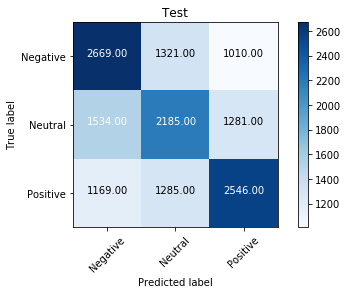

f1 score 0.4933333333333334
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2665 1334 1001]
 [1502 2109 1389]
 [1081 1279 2640]]


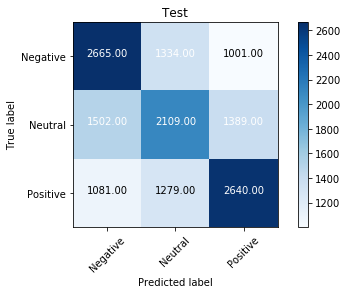

f1 score 0.4942666666666667
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2653 1393  954]
 [1440 2182 1378]
 [ 962 1345 2693]]


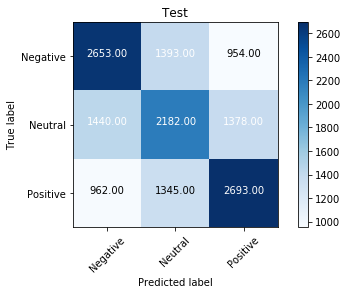

f1 score 0.5018666666666667
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2638 1453  909]
 [1409 2253 1338]
 [ 956 1379 2665]]


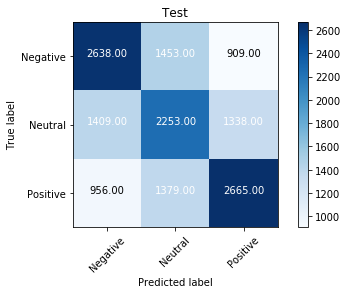

f1 score 0.5037333333333334
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2570 1560  870]
 [1331 2343 1326]
 [ 906 1467 2627]]


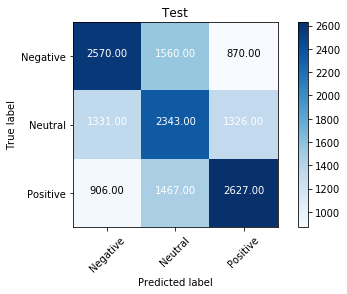

f1 score 0.5026666666666667
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2574 1565  861]
 [1295 2354 1351]
 [ 887 1482 2631]]


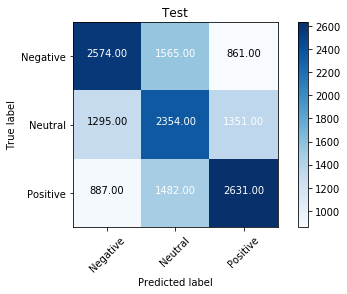

f1 score 0.5039333333333333
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2527 1630  843]
 [1225 2455 1320]
 [ 871 1550 2579]]


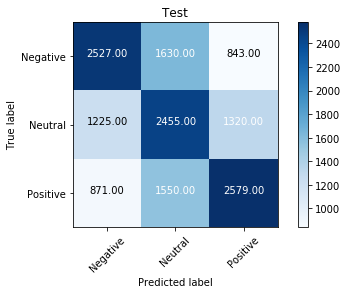

f1 score 0.5040666666666667
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2517 1667  816]
 [1213 2489 1298]
 [ 837 1592 2571]]


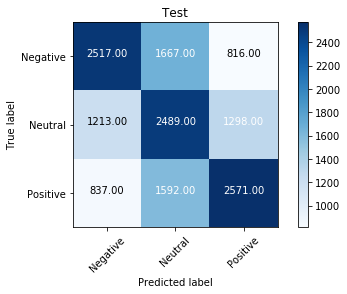

f1 score 0.5051333333333333
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2511 1674  815]
 [1239 2499 1262]
 [ 845 1619 2536]]


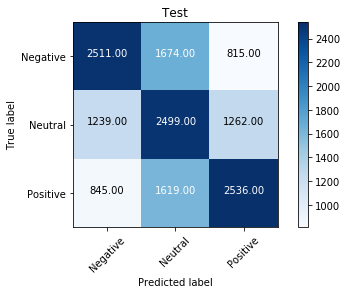

f1 score 0.5030666666666667
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2532 1691  777]
 [1238 2545 1217]
 [ 869 1667 2464]]


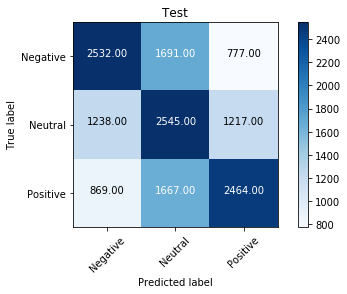

f1 score 0.5027333333333334
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3423 1040  537]
 [1357 2385 1258]
 [ 633 1140 3227]]


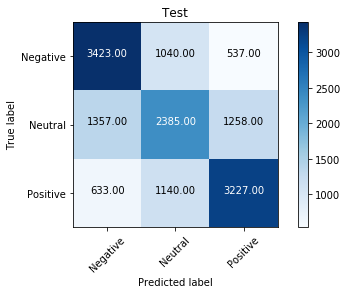

f1 score 0.6023333333333334
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3419 1097  484]
 [1342 2469 1189]
 [ 598 1171 3231]]


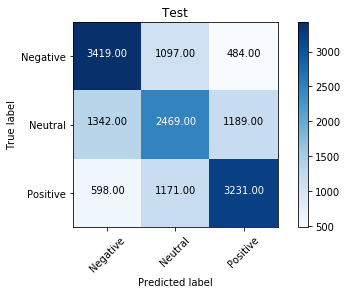

f1 score 0.6079333333333333
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3447 1104  449]
 [1348 2541 1111]
 [ 570 1238 3192]]


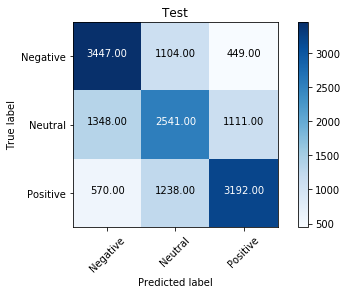

f1 score 0.612
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3430 1149  421]
 [1366 2562 1072]
 [ 576 1283 3141]]


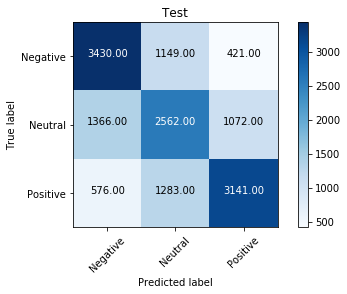

f1 score 0.6088666666666667
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3376 1220  404]
 [1340 2647 1013]
 [ 559 1352 3089]]


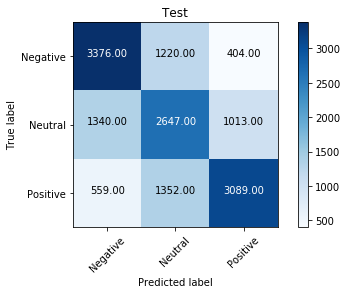

f1 score 0.6074666666666667
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3382 1242  376]
 [1309 2717  974]
 [ 561 1404 3035]]


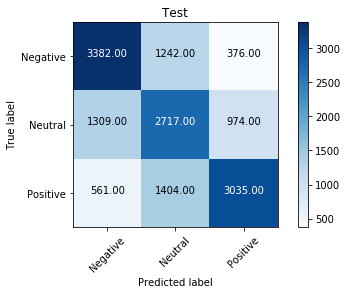

f1 score 0.6089333333333333
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3363 1270  367]
 [1280 2786  934]
 [ 555 1466 2979]]


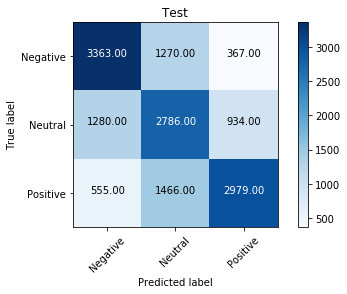

f1 score 0.6085333333333334
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3342 1306  352]
 [1258 2812  930]
 [ 556 1488 2956]]


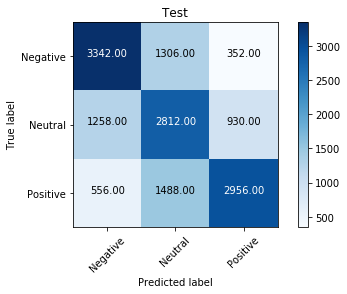

f1 score 0.6073333333333333
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3299 1360  341]
 [1230 2875  895]
 [ 555 1550 2895]]


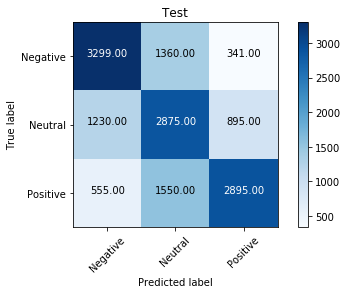

f1 score 0.6046
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3283 1389  328]
 [1200 2924  876]
 [ 558 1570 2872]]


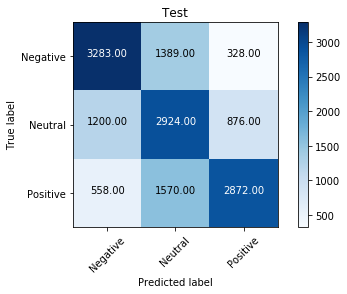

f1 score 0.6052666666666666
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[556 274 215]
 [295 474 276]
 [210 329 506]]


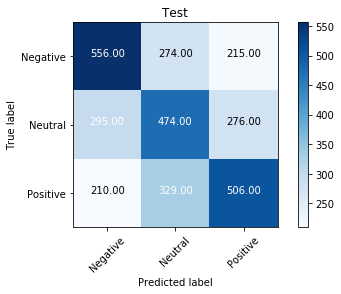

f1 score 0.48995215311004786
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[574 276 195]
 [296 483 266]
 [211 339 495]]


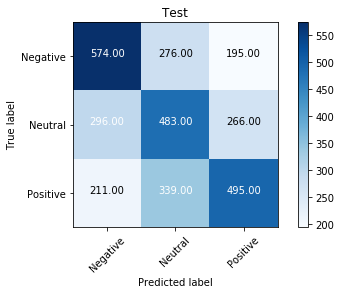

f1 score 0.49505582137161086
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[570 273 202]
 [287 485 273]
 [204 349 492]]


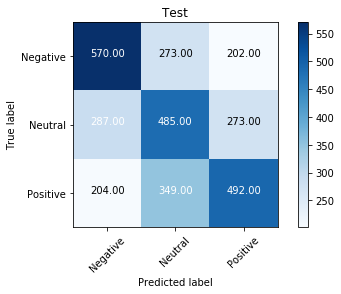

f1 score 0.49346092503987243
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[570 273 202]
 [287 485 273]
 [204 349 492]]


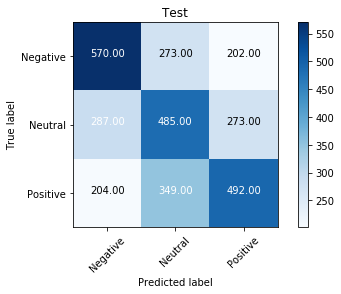

f1 score 0.49346092503987243
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[570 273 202]
 [287 485 273]
 [204 349 492]]


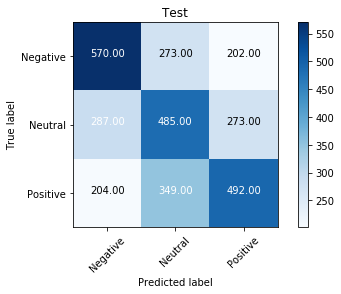

f1 score 0.49346092503987243
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[570 273 202]
 [287 485 273]
 [204 349 492]]


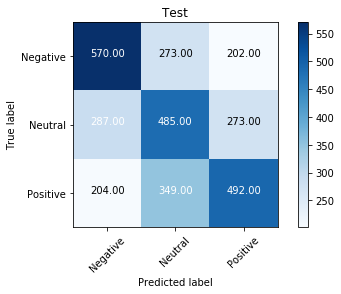

f1 score 0.49346092503987243
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[570 273 202]
 [287 485 273]
 [204 349 492]]


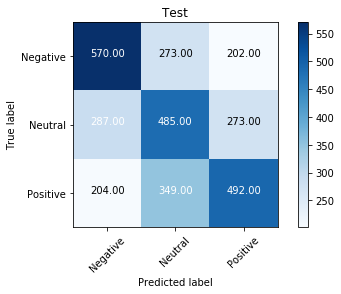

f1 score 0.49346092503987243
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[570 273 202]
 [287 485 273]
 [204 349 492]]


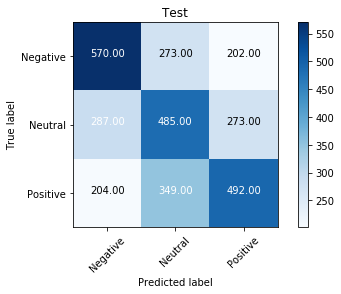

f1 score 0.49346092503987243
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[570 273 202]
 [287 485 273]
 [204 349 492]]


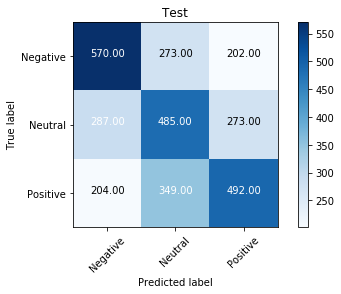

f1 score 0.49346092503987243
Train size: 300
Test size: 3135
Confusion matrix, without normalization
[[570 273 202]
 [287 485 273]
 [204 349 492]]


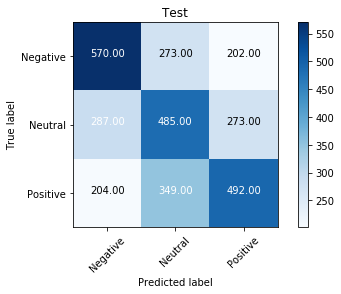

f1 score 0.49346092503987243
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[663 193 189]
 [256 470 319]
 [161 213 671]]


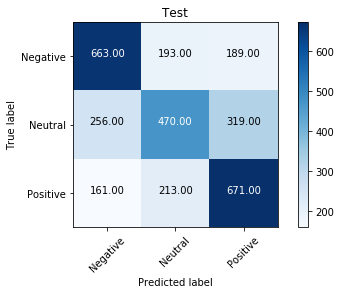

f1 score 0.5754385964912281
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[668 190 187]
 [255 470 320]
 [161 215 669]]


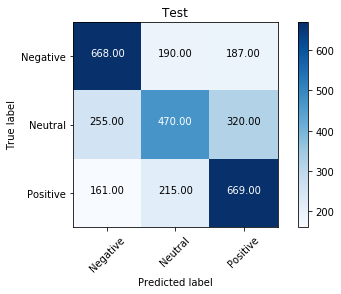

f1 score 0.5763955342902711
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[668 190 187]
 [255 470 320]
 [161 215 669]]


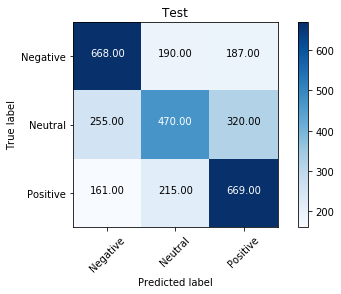

f1 score 0.5763955342902711
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[668 190 187]
 [255 470 320]
 [161 215 669]]


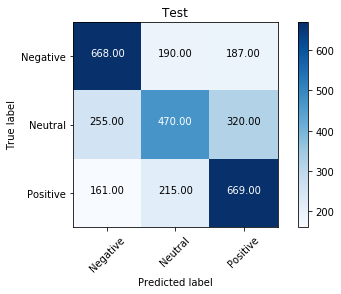

f1 score 0.5763955342902711
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[668 190 187]
 [255 470 320]
 [161 215 669]]


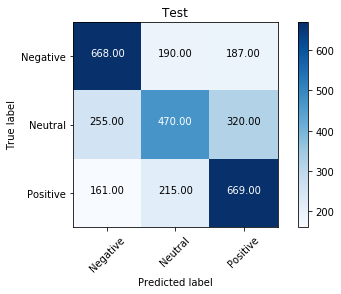

f1 score 0.5763955342902711
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[668 190 187]
 [255 470 320]
 [161 215 669]]


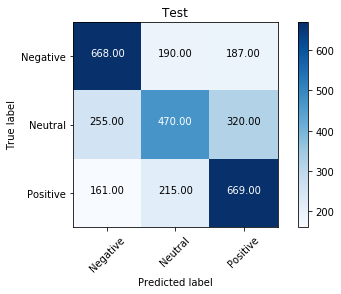

f1 score 0.5763955342902711
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[668 190 187]
 [255 470 320]
 [161 215 669]]


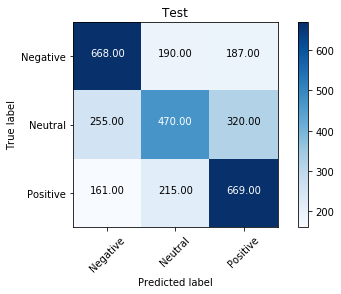

f1 score 0.5763955342902711
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[668 190 187]
 [255 470 320]
 [161 215 669]]


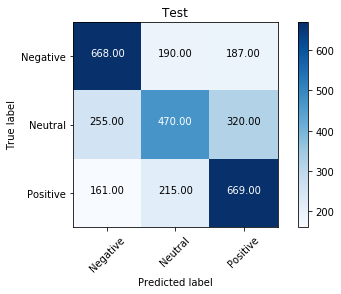

f1 score 0.5763955342902711
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[668 190 187]
 [255 470 320]
 [161 215 669]]


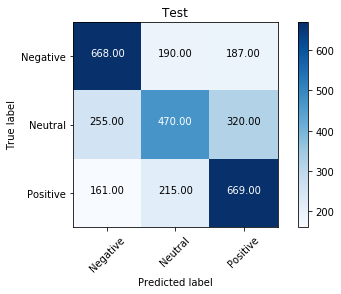

f1 score 0.5763955342902711
Train size: 3000
Test size: 3135
Confusion matrix, without normalization
[[668 190 187]
 [255 470 320]
 [161 215 669]]


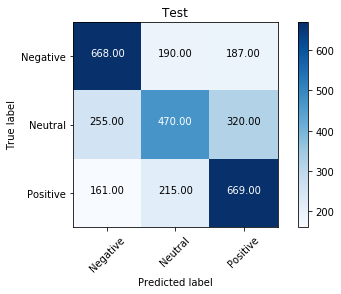

f1 score 0.5763955342902711


In [13]:
tasks = ['amazon_movies', 'semeval_task_a']
sub_tasks = ['fair_balanced_100', 'fair_balanced_1000'] #'fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'

stemmer = Stemmer()

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir
datasets_dir = repo_dir / "datasets"

f1_scores = []

for task in tasks:
    for subtask in sub_tasks:
        f1_column = []
        for f in [10,20,30,40,50,60,70,80,90,100]:
            df_trn = pd.read_csv(datasets_dir / task / subtask / "train.csv")
            df_val = pd.read_csv(datasets_dir / task / subtask / "validate.csv")
            print("Train size:", len(df_trn))
            print("Test size:", len(df_val))

            df_trn['text'] = df_trn['text'].astype(str)
            df_val['text'] = df_val['text'].astype(str)

            df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                          remove_users=True, 
                                                                                          remove_urls=True, 
                                                                                          remove_numbers=True))
            df_val['text'] = df_val['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                          remove_users=True, 
                                                                                          remove_urls=True, 
                                                                                          remove_numbers=True))

            tier = int(subtask.split('_')[-1])

            if task == 'amazon_movies' and subtask == 'fair_balanced_100':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,3),
                                     max_features=f*tier,
                                     tokenizer=lambda e: negate_sequence(e),
                                     binary=True)

                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = MultinomialNB(alpha=1.0, 
                                      fit_prior=True, 
                                      class_prior=None)
                
            if task == 'amazon_movies' and subtask == 'fair_balanced_1000':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,3),
                                     max_features=f*tier,
                                     tokenizer=lambda e: tokenizer_word(e,
                                                                        keep_phrases=False,
                                                                        tokenize_punc=True,
                                                                        split_clitics=False,
                                                                        keep_preceeding_space=False),
                                     binary=True)

                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = MultinomialNB(alpha=1.0, 
                                      fit_prior=True, 
                                      class_prior=None)
                
            if task == 'semeval_task_a':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=f*tier,
                                     tokenizer=lambda e: tokenizer_word(e,
                                                                        keep_phrases=False,
                                                                        tokenize_punc=True,
                                                                        split_clitics=False,
                                                                        keep_preceeding_space=False),
                                     binary=False)

                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = MultinomialNB(alpha=1.0, 
                                      fit_prior=True, 
                                      class_prior=None)

            model.fit(cv_data_trn, df_trn['label'])

            preds = model.predict(cv_data_val)
            cm_val = confusion_matrix(y_true=df_val["label"], y_pred=preds)
            plot_confusion_matrix(cm_val,
                                  ['Negative', 'Neutral', 'Positive'],
                                  normalize=False,
                                  title='Test')
            f1 = f1_score(df_val["label"], preds, average="micro")
            print("f1 score", f1)
            f1_column.append(f1)
        f1_scores.append(f1_column)

In [14]:
pd.DataFrame(np.array(f1_scores).T)

,0,1,2,3
0,0.493333,0.602333,0.489952,0.575439
1,0.494267,0.607933,0.495056,0.576396
2,0.501867,0.612000,0.493461,0.576396
3,0.503733,0.608867,0.493461,0.576396
4,0.502667,0.607467,0.493461,0.576396
5,0.503933,0.608933,0.493461,0.576396
6,0.504067,0.608533,0.493461,0.576396
7,0.505133,0.607333,0.493461,0.576396
8,0.503067,0.604600,0.493461,0.576396
9,0.502733,0.605267,0.493461,0.576396
